# Exploration 16
# 미니프로젝트: 다음에 볼 영화 예측하기📽
|---평가문항---|---상세기준---|
|:------|:------|
|1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.|데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.|
|2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.|적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.|
|3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.|3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.|

# 데이터 불러오기

In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [2]:
# 유저수(세션 수)와 아이템 수
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [3]:
# 유저별 리뷰 갯수
session_length = data.groupby('UserId').size()
session_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [4]:
# 리뷰 중앙값, 평균 리뷰 수
session_length.median(), session_length.mean()

(96.0, 165.5975165562914)

In [5]:
# 리뷰 최소값, 리뷰 최댓값
session_length.min(), session_length.max()

(20, 2314)

In [6]:
# 리뷰 분위수(전체 데이터의 0.999%)
session_length.quantile(0.999)

1343.181000000005

In [7]:
# 최다 리뷰자 확인해보기
long_session = session_length[session_length==2314].index[0]
data[data['UserId']==long_session]

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [8]:
# 세션 길이 식가화
# 세션길이 기준 하위 99.9%까지의 분포 누적합을 시각화
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

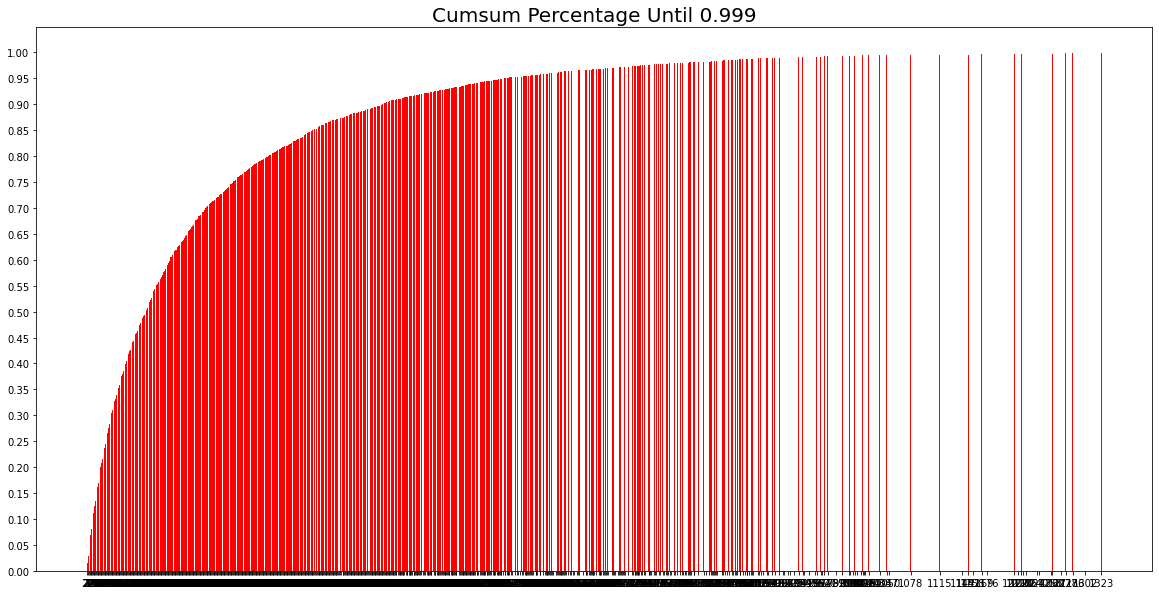

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

# 데이터 전처리

In [10]:
from datetime import datetime

def timestamp_convert(series_time):
    temp = series_time.copy()
    for i, v in enumerate(series_time):
        temp.iloc[i] = datetime.fromtimestamp(v)
    return temp

data['Time'] = timestamp_convert(data['Time'])
data.head()

,UserId,ItemId,Rating,Time
31,1,3186,4,2000-12-31 22:00:19
22,1,1270,5,2000-12-31 22:00:55
27,1,1721,4,2000-12-31 22:00:55
37,1,1022,5,2000-12-31 22:00:55
24,1,2340,3,2000-12-31 22:01:43


In [11]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


In [12]:
data = data[data['Rating'] >= 3]
print(len(data))

836478


In [13]:
# 유저 아이디와 시간으로 세션 아이디 만들기
data['SessionId'] = data.apply(lambda x: str(x['UserId']) + " : " + str(x['Time']), axis=1)
session_unique = data['SessionId'].unique() # 유니크한 값 뽑기
session_to_idx = {v:k for k,v in enumerate(session_unique)} # 인덱스 만들기

temp_session_data = data['SessionId'].map(session_to_idx.get).dropna()
data['SessionId'] = temp_session_data
data

,UserId,ItemId,Rating,Time,SessionId
31,1,3186,4,2000-12-31 22:00:19,0
22,1,1270,5,2000-12-31 22:00:55,1
27,1,1721,4,2000-12-31 22:00:55,1
37,1,1022,5,2000-12-31 22:00:55,1
24,1,2340,3,2000-12-31 22:01:43,2
...,...,...,...,...,...
1000019,6040,2917,4,2001-08-10 14:40:29,423404
999988,6040,1921,4,2001-08-10 14:41:04,423405
1000172,6040,1784,3,2001-08-10 14:41:04,423405
1000167,6040,161,3,2001-08-10 14:41:26,423406


In [14]:
# 컬럼 삭제
# 필요한 컬럼들만 남겨둔다
data = data[['SessionId', 'ItemId', 'Time']]
data

,SessionId,ItemId,Time
31,0,3186,2000-12-31 22:00:19
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
24,2,2340,2000-12-31 22:01:43
...,...,...,...
1000019,423404,2917,2001-08-10 14:40:29
999988,423405,1921,2001-08-10 14:41:04
1000172,423405,1784,2001-08-10 14:41:04
1000167,423406,161,2001-08-10 14:41:26


# Data Cleansing

In [15]:
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [16]:
# 클릭이 10회 미만인 데이터는 삭제해준다
data = cleanse_recursive(data, shortest=2, least_click=10)
data

,SessionId,ItemId,Time
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
7,5,2804,2000-12-31 22:11:59
47,5,1207,2000-12-31 22:11:59
...,...,...,...
1000162,423390,3362,2001-08-10 14:29:56
999917,423391,3421,2001-08-10 14:31:49
1000069,423391,1258,2001-08-10 14:31:49
999988,423405,1921,2001-08-10 14:41:04


# Train/Valid/Test Split

In [17]:
# 테스트 데이터는 최근 30일 기록
test_begin = latest - dt.timedelta(30) 
test = data[data['Time'] > test_begin]
test

,SessionId,ItemId,Time
53002,23569,145,2003-01-30 23:33:12
53058,23569,2699,2003-01-30 23:33:12
52934,23572,788,2003-01-30 23:37:06
53033,23572,185,2003-01-30 23:37:06
58660,26218,1503,2003-02-06 21:03:31
...,...,...,...
984807,417320,1300,2003-02-27 17:53:18
984501,417323,924,2003-02-27 17:54:22
984632,417323,3196,2003-02-27 17:54:22
984544,417331,3481,2003-02-27 18:04:50


In [18]:
# train은 3달 이전의 모든 데이터
train_begin = latest - dt.timedelta(90)
train = data[data['Time'] < train_begin]
train

,SessionId,ItemId,Time
22,1,1270,2000-12-31 22:00:55
27,1,1721,2000-12-31 22:00:55
37,1,1022,2000-12-31 22:00:55
7,5,2804,2000-12-31 22:11:59
47,5,1207,2000-12-31 22:11:59
...,...,...,...
1000162,423390,3362,2001-08-10 14:29:56
999917,423391,3421,2001-08-10 14:31:49
1000069,423391,1258,2001-08-10 14:31:49
999988,423405,1921,2001-08-10 14:41:04


In [19]:
# valid는 train과 test 데이터 사이의 모든 데이터
valid_condition = (data['Time'] > train_begin) & (data['Time'] < test_begin)
valid = data[valid_condition]
valid

,SessionId,ItemId,Time
5200,2542,2269,2002-12-22 08:05:50
5256,2542,1701,2002-12-22 08:05:50
5062,2549,1266,2002-12-22 08:18:29
5076,2549,595,2002-12-22 08:18:29
5126,2549,1295,2002-12-22 08:18:29
...,...,...,...
974738,412982,2005,2003-01-28 20:14:28
974310,412983,2115,2003-01-28 20:14:44
974333,412983,2140,2003-01-28 20:14:44
974210,412987,2413,2003-01-28 20:17:48


In [20]:
# data에 대한 정보 출력하는 함수
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [21]:
stats_info(train, 'train')
stats_info(valid, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 613815
	 Sessions: 204121
	 Items: 2933
	 First Time : 2000-04-25 23:05:54
	 Last Time : 2002-11-29 22:22:53

* valid Set Stats Info
	 Events: 1047
	 Sessions: 396
	 Items: 705
	 First Time : 2002-12-01 16:08:30
	 Last Time : 2003-01-29 00:11:54

* test Set Stats Info
	 Events: 545
	 Sessions: 228
	 Items: 458
	 First Time : 2003-01-30 15:50:01
	 Last Time : 2003-02-28 17:49:08



In [22]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱한다
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해준다.
    return df

train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

train

,SessionId,ItemId,Time,item_idx
22,1,1270,2000-12-31 22:00:55,0
27,1,1721,2000-12-31 22:00:55,1
37,1,1022,2000-12-31 22:00:55,2
7,5,2804,2000-12-31 22:11:59,3
47,5,1207,2000-12-31 22:11:59,4
...,...,...,...,...
1000162,423390,3362,2001-08-10 14:29:56,1069
999917,423391,3421,2001-08-10 14:31:49,132
1000069,423391,1258,2001-08-10 14:31:49,799
999988,423405,1921,2001-08-10 14:41:04,433


In [23]:
valid

,SessionId,ItemId,Time,item_idx
5200,2542,2269,2002-12-22 08:05:50,2536
5256,2542,1701,2002-12-22 08:05:50,1504
5062,2549,1266,2002-12-22 08:18:29,1015
5076,2549,595,2002-12-22 08:18:29,21
5126,2549,1295,2002-12-22 08:18:29,1483
...,...,...,...,...
974738,412982,2005,2003-01-28 20:14:28,476
974310,412983,2115,2003-01-28 20:14:44,129
974333,412983,2140,2003-01-28 20:14:44,518
974210,412987,2413,2003-01-28 20:17:48,837


In [24]:
test

,SessionId,ItemId,Time,item_idx
53002,23569,145,2003-01-30 23:33:12,1773
53058,23569,2699,2003-01-30 23:33:12,301
52934,23572,788,2003-01-30 23:37:06,1438
53033,23572,185,2003-01-30 23:37:06,1262
58660,26218,1503,2003-02-06 21:03:31,2597
...,...,...,...,...
984807,417320,1300,2003-02-27 17:53:18,1101
984501,417323,924,2003-02-27 17:54:22,687
984632,417323,3196,2003-02-27 17:54:22,1216
984544,417331,3481,2003-02-27 18:04:50,296


In [25]:
# 데이터 저장
save_path = data_path / 'processed'
save_path.mkdir(parents=True, exist_ok=True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

# 미니 배치의 구성
# SessionDataset

In [26]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets() # 각 세션이 시작된 인덱스
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # 각 세션을 인덱싱한 np.array

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [27]:
# train 데이터로 SessionDataset 객체를 만들고 인스턴스 변수들을 살펴본다
tr_dataset = SessionDataset(train)
tr_dataset.df.head(10)

,SessionId,ItemId,Time,item_idx
22,1,1270,2000-12-31 22:00:55,0
27,1,1721,2000-12-31 22:00:55,1
37,1,1022,2000-12-31 22:00:55,2
7,5,2804,2000-12-31 22:11:59,3
47,5,1207,2000-12-31 22:11:59,4
0,6,1193,2000-12-31 22:12:40,5
21,6,720,2000-12-31 22:12:40,6
44,6,260,2000-12-31 22:12:40,7
14,14,1035,2000-12-31 22:29:13,8
42,14,1962,2000-12-31 22:29:13,9


In [28]:
# 각 세션이 시작된 인덱스
tr_dataset.click_offsets

array([     0,      3,      5, ..., 613811, 613813, 613815], dtype=int32)

In [29]:
# 각 세션을 인덱싱한 np.array
tr_dataset.session_idx

array([     0,      1,      2, ..., 204118, 204119, 204120])

# SessionDataLoader

In [30]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [31]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

,SessionId,ItemId,Time,item_idx
22,1,1270,2000-12-31 22:00:55,0
27,1,1721,2000-12-31 22:00:55,1
37,1,1022,2000-12-31 22:00:55,2
7,5,2804,2000-12-31 22:11:59,3
47,5,1207,2000-12-31 22:11:59,4
0,6,1193,2000-12-31 22:12:40,5
21,6,720,2000-12-31 22:12:40,6
44,6,260,2000-12-31 22:12:40,7
14,14,1035,2000-12-31 22:29:13,8
42,14,1962,2000-12-31 22:29:13,9


In [32]:
iter_ex = iter(tr_data_loader)

In [33]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [0 3 5 8]
Label Item Idx are :       [1 4 6 9]
Previous Masked Input Idx are []


# 모델 구성
# Evaluation Metric

In [34]:
# MRR
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0

# recall@k
def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

# Model Architecture

In [35]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [36]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    
    return model

In [37]:
# 모델에 사용할 hyper-parameter를 class형식으로 관리
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k
        
args = Args(train, valid, test, batch_size=32, hsz=32, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [38]:
model = create_model(args)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 2933)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 32), (32, 32)]      284832    
_________________________________________________________________
dropout (Dropout)            (32, 32)                  0         
_________________________________________________________________
dense (Dense)                (32, 2933)                96789     
Total params: 381,621
Trainable params: 381,621
Non-trainable params: 0
_________________________________________________________________


# 모델학습

In [39]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [40]:
train_model(model, args)

Evaluation:  95%|█████████▌| 19/20 [00:04<00:00,  4.31it/s]


	 - Recall@20 epoch 1: 0.185855
	 - MRR@20    epoch 1: 0.058999



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.42it/s]


	 - Recall@20 epoch 2: 0.256579
	 - MRR@20    epoch 2: 0.091997



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.65it/s]


	 - Recall@20 epoch 3: 0.273026
	 - MRR@20    epoch 3: 0.098473



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.47it/s]


	 - Recall@20 epoch 4: 0.276316
	 - MRR@20    epoch 4: 0.102996



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.78it/s]


	 - Recall@20 epoch 5: 0.279605
	 - MRR@20    epoch 5: 0.106104



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.42it/s]


	 - Recall@20 epoch 6: 0.282895
	 - MRR@20    epoch 6: 0.105800



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.43it/s]


	 - Recall@20 epoch 7: 0.281250
	 - MRR@20    epoch 7: 0.108523



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.54it/s]


	 - Recall@20 epoch 8: 0.281250
	 - MRR@20    epoch 8: 0.111439



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.39it/s]


	 - Recall@20 epoch 9: 0.282895
	 - MRR@20    epoch 9: 0.111243



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.76it/s]

	 - Recall@20 epoch 10: 0.281250
	 - MRR@20    epoch 10: 0.113416



# 모델 테스트

In [41]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print()
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation: 100%|██████████| 9/9 [00:01<00:00,  5.53it/s]


	 - Recall@20: 0.229167
	 - MRR@20: 0.081016



# 모델 개선
# 1. hsz를 32 -> 64 변경

In [42]:
args = Args(train, valid, test, batch_size=32, hsz=64, drop_rate=0.1, lr=0.001, epochs=10, k=20)

model = create_model(args)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(32, 1, 2933)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 64), (32, 64)]      575808    
_________________________________________________________________
dropout_1 (Dropout)          (32, 64)                  0         
_________________________________________________________________
dense_1 (Dense)              (32, 2933)                190645    
Total params: 766,453
Trainable params: 766,453
Non-trainable params: 0
_________________________________________________________________


In [43]:
train_model(model, args)

Evaluation:  95%|█████████▌| 19/20 [00:04<00:00,  4.52it/s]


	 - Recall@20 epoch 1: 0.226974
	 - MRR@20    epoch 1: 0.080658



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.63it/s]


	 - Recall@20 epoch 2: 0.269737
	 - MRR@20    epoch 2: 0.104380



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.71it/s]


	 - Recall@20 epoch 3: 0.269737
	 - MRR@20    epoch 3: 0.107171



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.49it/s]


	 - Recall@20 epoch 4: 0.269737
	 - MRR@20    epoch 4: 0.110798



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.83it/s]


	 - Recall@20 epoch 5: 0.274671
	 - MRR@20    epoch 5: 0.104681



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.71it/s]


	 - Recall@20 epoch 6: 0.281250
	 - MRR@20    epoch 6: 0.104010



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.68it/s]


	 - Recall@20 epoch 7: 0.286184
	 - MRR@20    epoch 7: 0.107865



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.76it/s]


	 - Recall@20 epoch 8: 0.279605
	 - MRR@20    epoch 8: 0.106414



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.52it/s]


	 - Recall@20 epoch 9: 0.281250
	 - MRR@20    epoch 9: 0.106043



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.73it/s]

	 - Recall@20 epoch 10: 0.282895
	 - MRR@20    epoch 10: 0.105807



In [44]:
test_model(model, args, test)

Evaluation: 100%|██████████| 9/9 [00:01<00:00,  5.39it/s]


	 - Recall@20: 0.218750
	 - MRR@20: 0.075934



# 모델 개선
# 2. drop_rate를 0.1 -> 0.5 변경

In [45]:
args = Args(train, valid, test, batch_size=32, hsz=64, drop_rate=0.5, lr=0.001, epochs=10, k=20)

model = create_model(args)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(32, 1, 2933)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 64), (32, 64)]      575808    
_________________________________________________________________
dropout_2 (Dropout)          (32, 64)                  0         
_________________________________________________________________
dense_2 (Dense)              (32, 2933)                190645    
Total params: 766,453
Trainable params: 766,453
Non-trainable params: 0
_________________________________________________________________


In [46]:
train_model(model, args)

Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.00it/s]


	 - Recall@20 epoch 1: 0.197368
	 - MRR@20    epoch 1: 0.068771



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.30it/s]


	 - Recall@20 epoch 2: 0.258224
	 - MRR@20    epoch 2: 0.095433



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.82it/s]


	 - Recall@20 epoch 3: 0.269737
	 - MRR@20    epoch 3: 0.103124



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.62it/s]


	 - Recall@20 epoch 4: 0.276316
	 - MRR@20    epoch 4: 0.101738



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.58it/s]


	 - Recall@20 epoch 5: 0.281250
	 - MRR@20    epoch 5: 0.104333



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.45it/s]


	 - Recall@20 epoch 6: 0.284539
	 - MRR@20    epoch 6: 0.106774



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.79it/s]


	 - Recall@20 epoch 7: 0.286184
	 - MRR@20    epoch 7: 0.104288



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.73it/s]


	 - Recall@20 epoch 8: 0.284539
	 - MRR@20    epoch 8: 0.106770



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.53it/s]


	 - Recall@20 epoch 9: 0.277961
	 - MRR@20    epoch 9: 0.110212



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.75it/s]

	 - Recall@20 epoch 10: 0.281250
	 - MRR@20    epoch 10: 0.108285



# 모델 개선
# 3. lr를 0.001 -> 0.0008 변경

In [47]:
args = Args(train, valid, test, batch_size=32, hsz=64, drop_rate=0.5, lr=0.0008, epochs=10, k=20)

model = create_model(args)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(32, 1, 2933)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 64), (32, 64)]      575808    
_________________________________________________________________
dropout_3 (Dropout)          (32, 64)                  0         
_________________________________________________________________
dense_3 (Dense)              (32, 2933)                190645    
Total params: 766,453
Trainable params: 766,453
Non-trainable params: 0
_________________________________________________________________


In [48]:
train_model(model, args)

Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  4.99it/s]


	 - Recall@20 epoch 1: 0.175987
	 - MRR@20    epoch 1: 0.064280



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.61it/s]


	 - Recall@20 epoch 2: 0.253289
	 - MRR@20    epoch 2: 0.095923



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.60it/s]


	 - Recall@20 epoch 3: 0.269737
	 - MRR@20    epoch 3: 0.103202



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.76it/s]


	 - Recall@20 epoch 4: 0.277961
	 - MRR@20    epoch 4: 0.109888



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.55it/s]


	 - Recall@20 epoch 5: 0.276316
	 - MRR@20    epoch 5: 0.105279



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.88it/s]


	 - Recall@20 epoch 6: 0.286184
	 - MRR@20    epoch 6: 0.108315



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.56it/s]


	 - Recall@20 epoch 7: 0.277961
	 - MRR@20    epoch 7: 0.101257



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.79it/s]


	 - Recall@20 epoch 8: 0.286184
	 - MRR@20    epoch 8: 0.108681



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.46it/s]


	 - Recall@20 epoch 9: 0.269737
	 - MRR@20    epoch 9: 0.107902



Evaluation:  95%|█████████▌| 19/20 [00:03<00:00,  5.70it/s]

	 - Recall@20 epoch 10: 0.281250
	 - MRR@20    epoch 10: 0.104310



In [49]:
test_model(model, args, test)

Evaluation: 100%|██████████| 9/9 [00:01<00:00,  5.37it/s]


	 - Recall@20: 0.239583
	 - MRR@20: 0.079865



# 모델 개선
# 4. batch_size를 32 -> 128 변경

In [50]:
args = Args(train, valid, test, batch_size=128, hsz=64, drop_rate=0.5, lr=0.0008, epochs=10, k=20)

model = create_model(args)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(128, 1, 2933)]          0         
_________________________________________________________________
GRU (GRU)                    [(128, 64), (128, 64)]    575808    
_________________________________________________________________
dropout_4 (Dropout)          (128, 64)                 0         
_________________________________________________________________
dense_4 (Dense)              (128, 2933)               190645    
Total params: 766,453
Trainable params: 766,453
Non-trainable params: 0
_________________________________________________________________


In [51]:
train_model(model, args)

Evaluation:  80%|████████  | 4/5 [00:03<00:00,  1.26it/s]


	 - Recall@20 epoch 1: 0.082031
	 - MRR@20    epoch 1: 0.022055



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.63it/s]


	 - Recall@20 epoch 2: 0.150391
	 - MRR@20    epoch 2: 0.058088



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.61it/s]


	 - Recall@20 epoch 3: 0.199219
	 - MRR@20    epoch 3: 0.072747



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]


	 - Recall@20 epoch 4: 0.212891
	 - MRR@20    epoch 4: 0.080449



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.51it/s]


	 - Recall@20 epoch 5: 0.222656
	 - MRR@20    epoch 5: 0.083521



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.57it/s]


	 - Recall@20 epoch 6: 0.234375
	 - MRR@20    epoch 6: 0.088401



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.65it/s]


	 - Recall@20 epoch 7: 0.232422
	 - MRR@20    epoch 7: 0.085936



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.69it/s]


	 - Recall@20 epoch 8: 0.230469
	 - MRR@20    epoch 8: 0.088153



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.68it/s]


	 - Recall@20 epoch 9: 0.238281
	 - MRR@20    epoch 9: 0.089890



Evaluation:  80%|████████  | 4/5 [00:02<00:00,  1.59it/s]

	 - Recall@20 epoch 10: 0.240234
	 - MRR@20    epoch 10: 0.092332



In [52]:
test_model(model, args, test)

Evaluation: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]


	 - Recall@20: 0.210938
	 - MRR@20: 0.075393



# 회고
- 아쉬운점
  - 모델을 학습 시키는데 시간이 많이 걸려서 다른 시도도 해보고 싶었지만 시간이 없어서 못했다.
  
  
- 지금까지 해본 노드 중에 가장 어려웠던것같다.
- 결과를 보고 비교해야하는데 이 수치가 어느 정도 좋아야 좋은 모델인지 잘 모르겠다.
- 지금은 시간이 없지만 후에 다시 한번 더 찾아보고 다른 분들과도 얘기를 나누어 봐야겠다. 